# Video summarization with DL embeddings (part I)

This notebook is a start of my quest to find a way to summarize video content with a relatively small number of images

Specifically, I want to figure out the way to cluster all frames the video contains and then simply select a few images that better characterize these clusters - quite possibly it can be done by pushing all frames through some sophisticated CNN model (I pick GoogLeNet) and performing clustering on the resulting embeddings - this is the main direction I plan to pursue

However, this is still only the beginning - at this stage I am more interested in building some proofs of concept so below you will find the code to:
* download YouTube videos and to process them using OpenCV
* set up the Keras implementation of GoogLeNet model and use it for image classification and getting DL embeddings
* calculate all frame embeddings for a single video and visualize them using t-sne projection

## Importing necessary libraries

Importing necessary stuff to download and process video frames

It is worth mentioning that currently I am using opencv and it may be somewhat heavy library to deal with - potentially cv2 bits can be replaced with imageio which is easier to start with but has less functionality:

In [1]:
import sys
import os.path
import youtube_dl as yt
import cv2
import numpy as np
from sklearn.manifold import TSNE

Importing necessary stuff for GoogleNet model taken from here: http://joelouismarino.github.io/blog_posts/blog_googlenet_keras.html

Note that in order to have everything working:
* The contents of zip file (googlenet_architecture.json, googlenet_weights.h5, googlenet_custom_layers.py) should be in the same folder as this jupyter notebook
* keras should be using theano backend (in C:/Users/"your_user"/.keras/keras.json" file "backend" field should be set to "theano" and "image_dim_ordering" field should be set to "th")

In [2]:
import keras
import theano
from keras import backend as K
from keras.models import model_from_json
from googlenet_custom_layers import PoolHelper,LRN

Using Theano backend.


Importing necessary stuff to visualize my results and track my intermediate progress

In [3]:
from IPython.display import YouTubeVideo
from tqdm import tqdm
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
%matplotlib inline

## Selecting several video from dataset and downloading them

In [5]:
video_ids = ["4k2qR0pNCtw", "p3DmskFgDww", "AI5bWJQMjGo", "MHbF3FHPvL4", "A2w_Gc12PuE"]

A bit of info about the videos:
* "4k2qR0pNCtw" is Haydn Op.76 string quartet
* "p3DmskFgDww" is a video with kittens
* "AI5bWJQMjGo" is a walkthrough of one mission from GTA San Andreas
* "MHbF3FHPvL4" is a trailer of South Park: Stick of Truth video game
* "A2w_Gc12PuE" is a frame of Kenny from South Park with Princess Kenny song in the background

In [6]:
ydl_opts = {"outtmpl" : "Videos/%(id)s.%(ext)s", 
            "writedescription" : True,
            "writeannotations" : True,
            "writethumbnail" : True,
            "format" : "mp4"
           }

for video in video_ids:
    if not os.path.isfile("Videos/" + video + ".mp4"):
        yt.YoutubeDL(ydl_opts).download(["http://www.youtube.com/watch?v=" + video])

## Checking I can read videos and select frames from them

In this section I load one cat video and select one frame from it - mostly to get hold on opencv functionality

Additionally, later on I want to throw the selected frame to GoogLeNet model and, ideally, have it classified as containing cats

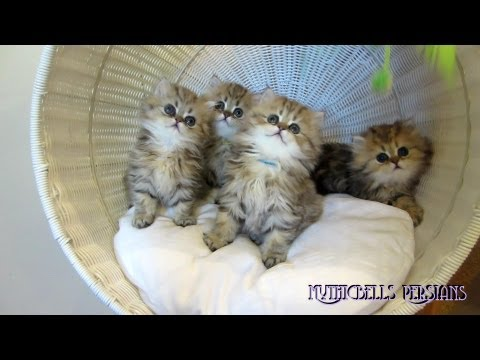

In [7]:
video_pick = 1
YouTubeVideo(video_ids[video_pick])

In [8]:
video_reader = cv2.VideoCapture("Videos/" + video_ids[video_pick] + ".mp4")

More details on VideoCapture object and its methods can be found here: http://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html

To explain what is going on below:
* video_reader.get(7) gets CV_CAP_PROP_FRAME_COUNT (the number of frames in the video)
* video_reader.set(1, 2500) sets CV_CAP_PROP_POS_FRAMES (0-based index for frames) to 2500

In [9]:
print("The total number of frames in selected video is " + str(int(video_reader.get(7))))

The total number of frames in selected video is 4062


In [10]:
video_reader.set(1, 2500)
bool_flag, test_frame = video_reader.read()

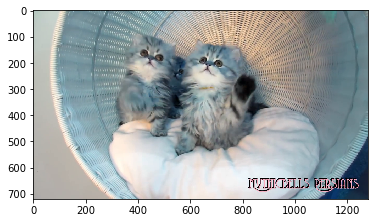

In [11]:
plt.imshow(test_frame)
plt.show()

## Checking I can run GoogLeNet model and get frame embeddings

Reading the GoogLeNet model: notice that input requirements for the model differ from images shape so preprocessing steps are needed

In [12]:
gln = model_from_json(open('googlenet_architecture.json').read(),custom_objects={"PoolHelper": PoolHelper,"LRN":LRN})
gln.load_weights('googlenet_weights.h5')

In [13]:
# print([x.name for x in gln.layers])

In [14]:
print(gln.input_shape)
print(test_frame.shape)

(None, 3, 224, 224)
(720, 1280, 3)


Selecting a part of original frame / resizing original frame in order to match GoogLeNet input requirements

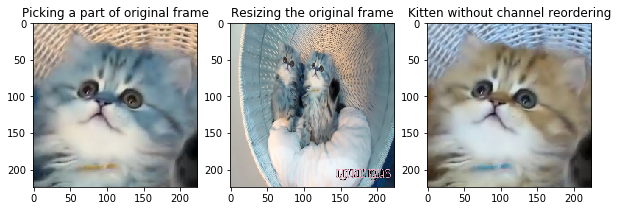

In [15]:
cat_image = test_frame[100:100 + 224, 575:575+224, :]
resized_frame = cv2.resize(test_frame, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(cat_image)
plt.title("Picking a part of original frame")
plt.subplot(1, 3, 2)
plt.imshow(resized_frame)
plt.title("Resizing the original frame")
plt.subplot(1, 3, 3)
plt.imshow(cat_image[:, :, [2, 1, 0]])
plt.title("Kitten without channel reordering")
plt.show()

First, dealing with the cropped cat image and classifying it with GoogLeNet: as with the model itself, the processing steps are taken from http://joelouismarino.github.io/blog_posts/blog_googlenet_keras.html

These steps themselves are "subtracting the channels means, changing the channel ordering, switching the spatial and channel dimensions, adding an extra dimension for the batch" and afterwards copypasting a function to get the output of a specific layer in the neural network

Important note: I had some problems with channel reordering. I still left it in place to mimick the processing steps as in the link above but I have better prediction if I do not do it (that way the image passed to GoogLeNet has a rather brownish than greyish kitten)

In [16]:
gln_test_image = resized_frame.astype("float64")
gln_test_image = gln_test_image.transpose((2, 0, 1))
gln_test_image[0, :, :] -= np.mean(gln_test_image[0, :, :])
gln_test_image[1, :, :] -= np.mean(gln_test_image[1, :, :])
gln_test_image[2, :, :] -= np.mean(gln_test_image[2, :, :])
gln_test_image[[0, 1, 2], :, :] = gln_test_image[[2, 1, 0], :, :]
gln_test_image = np.expand_dims(gln_test_image, axis=0)

In [17]:
def get_activations(model, layer, X_batch):
    get_activations = theano.function([model.layers[0].input,K.learning_phase()], layer.output, allow_input_downcast=True)
    activations = get_activations(X_batch,0)
    return activations

In [18]:
gln_pred = get_activations(gln, gln.get_layer("prob"), gln_test_image)

top_inds = gln_pred[0].argsort()[::-1][:5]
print(top_inds)
print([gln_pred[0][x] for x in top_inds])

[283 155 187 282 359]
[0.29103395, 0.19767173, 0.075658083, 0.042304639, 0.039375797]


The arrays above stand for top 5 picked labels and corresponding estimated probabilities 

Details about what these labels are about can be found here: https://gist.github.com/maraoz/388eddec39d60c6d52d4
* 283: Persian cat
* 155: Shih-Tzu
* 187: Yorkshire terrier
* 282: tiger cat
* 359: black-footed ferret

Thus, the classifier seems to work (the video indeed shows persian kittens), moving on to defining a function to get frame embeddings from GoogLeNet (the picked layer is "pool5/7x7_s2" - it occurs after all inception blocks and returns a tensor of (1, 1024, 1, 1) shape)

In [19]:
def get_layer_output(model, layer, X_batch):
    get_activations = theano.function([model.layers[0].input], layer.output, allow_input_downcast=True)
    layer_output = get_activations(X_batch)
    return layer_output

def gln_embedding(original_frame):
    frame = cv2.resize(original_frame, (224, 224)).astype("float64")
    frame = frame.transpose((2, 0, 1))
    frame[0, :, :] -= np.mean(frame[0, :, :])
    frame[1, :, :] -= np.mean(frame[1, :, :])
    frame[2, :, :] -= np.mean(frame[2, :, :])
    frame[[0, 1, 2], :, :] = frame[[2, 1, 0], :, :]
    frame = np.expand_dims(frame, axis=0)
    output = get_layer_output(gln, gln.get_layer("pool5/7x7_s2"), frame)
    return output[0, :, 0, 0]

In [20]:
embedding_test = gln_embedding(test_frame)
print (embedding_test.shape)
print (embedding_test)

(1024,)
[ -2.91941120e-08   2.34105214e-01   1.02739803e-01 ...,   8.96369889e-02
   2.23517418e-08   1.87778339e-01]


Everything seems to work! At this point I can get GoogLeNet embeddings for video frames - time to scale it up, embed all frames from a selected video and use t-sne projection in order to check whether it makes sense to search for clusters within these embeddings if I want to select frames that summarize the original video

## Embedding all video frames and using t-sne projection

In this section I calculate GoogLeNet embeddings for "all" frames of the video - as it was mentioned before, the original idea is that finding clusters within these embeddings would allow to summarize the whole video with a relatively small amount of video frames

However, at this point I only try to assess whether such clustering is in general possible - the conventional approach to consider whether there are any clusters among t-sne projections of original data

For the sake of variety leaving kittens alone and moving to some other video:

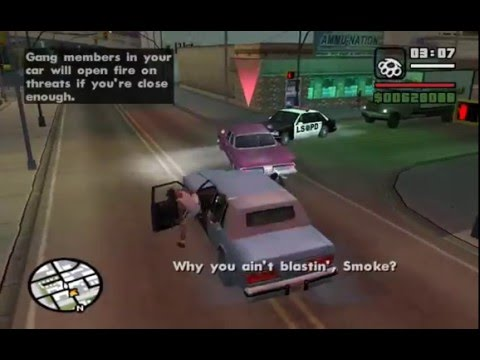

In [17]:
video_pick = 2
YouTubeVideo(video_ids[video_pick])

In [8]:
video_reader = cv2.VideoCapture("Videos/" + video_ids[video_pick] + ".mp4")

In order to avoid huge amount of computations I decided to impose the approximate cap of how many frames will be processed - 1000 seems a reasonable amount to properly describe ~5-10 minute videos and still should not put too much pressure computationally

In [9]:
target_num_frames = 1000
sample_rate = max(1, int(video_reader.get(7) / target_num_frames))
picked_frames = range(0, int(video_reader.get(7)), sample_rate)

In [10]:
frame_embeddings = np.zeros((len(picked_frames), 1024))
embeddings_filename = "Videos/" + video_ids[video_pick] + "_embeddings.txt"

if not os.path.isfile(embeddings_filename):
    for i in tqdm(range(len(picked_frames))):
        frame_num = picked_frames[i]
        video_reader.set(1, frame_num)
        bool_flag, frame = video_reader.read()  
        frame_embeddings[i, :] = gln_embedding(frame)
    np.savetxt(embeddings_filename, frame_embeddings)
else:
    frame_embeddings = np.loadtxt(embeddings_filename)

The calculations of embeddings above should be the most lengthy stage - after that calculation of t-sne projections and plotting the final results are pretty straightforward

Still, I took some extra effort to visualize final results with bokeh (that way the plot is interactive) - feel free to zoom in and explore the frame mapping 

In [12]:
tsne_model = TSNE(n_components=2)
tsne_proj = tsne_model.fit_transform(frame_embeddings)

In [21]:
try:
    os.makedirs("tsne_images/" + video_ids[video_pick])
except:
    pass

plot = figure(tools="pan,wheel_zoom,reset,save",
              toolbar_location="above",
              title="T-SNE for video frame embeddings",
              width=750,
              height=750,
              x_range=(min(tsne_proj[:, 0]), max(tsne_proj[:, 0])),
              y_range=(min(tsne_proj[:, 1]), max(tsne_proj[:, 1]))
             )

for i in tqdm(range(len(picked_frames))):
    frame_num = picked_frames[i]
    video_reader.set(1, frame_num)
    bool_flag, frame = video_reader.read()  
    temp_filepath = "tsne_images/" + video_ids[video_pick] + "/" + str(frame_num) + ".png"
    cv2.imwrite(temp_filepath, frame)
    plot.image_url(url=[temp_filepath], x=tsne_proj[i, 0], y=tsne_proj[i, 1], w=1, h=1)

show(plot)

100%|██████████████████████████████████████| 1081/1081 [02:19<00:00,  4.66it/s]


Success! The resulting t-sne projection puts similar frames together (this implies that corresponding GoogLeNet embeddings are also close to each other) but on the other hand still allows for different clusters of frames - with such results clustering of DL embeddings looks very promising for video summarization and will be approached in part II